<a href="https://colab.research.google.com/github/dev4hobby/ListenAndTranscript/blob/master/ListenAndTranscript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [37]:
data_dir = pathlib.Path('data')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'CustomSortedOnlySingleChannel.zip',
      origin="http://media.d3fau1t.net/CustomSortedOnlySingleChannel.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [38]:
sounds = np.array(tf.io.gfile.listdir(str(data_dir)))
sounds = list(set(sounds) - set(['README.md', '.ipynb_checkpoints', '.DS_Store']))
print('Sounds:', sounds)

Sounds: ['RackTomRim', 'KickPress', 'SnareCrossStick', 'HiHatFoot', 'KickRelease', 'Crash', 'CrashClamp', 'CrashTip', 'SnareRim', 'FloorTomBuzz', 'RackTomStrike', 'SnareBuzz', 'FloorTomRim', 'FloorTomStrike', 'SnareStrike', 'HiHatTip', 'Ride', 'RackTomBuzz']


In [39]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/sounds[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 1718
Number of examples per label: 96
Example file tensor: tf.Tensor(b'data/RackTomBuzz/_IN_RackTom_Buzz_0113.4.wav_ch1.wav', shape=(), dtype=string)


In [40]:
print(len(filenames))
train_files = filenames[:1380]
val_files = filenames[1380: 1380 + 356]
test_files = filenames[-356:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


1718
Training set size 1380
Validation set size 338
Test set size 356


In [41]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [42]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [43]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform[:20000], label

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


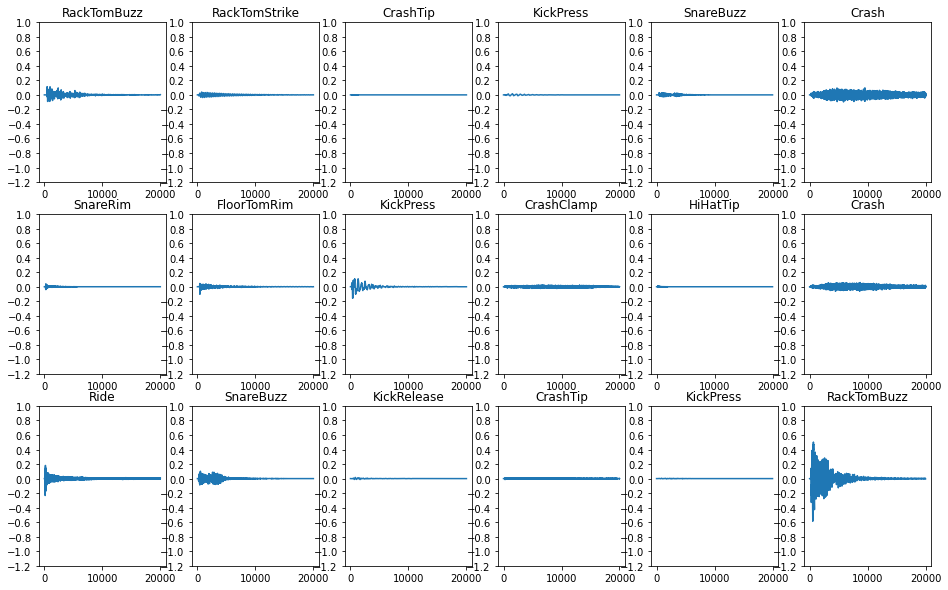

In [45]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [46]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  
  zero_padding = tf.zeros([20000] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.cast(waveform, tf.float32)
  waveform = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [47]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

Label: RackTomBuzz
Waveform shape: (20000,)
Spectrogram shape: (155, 129)
Audio playback


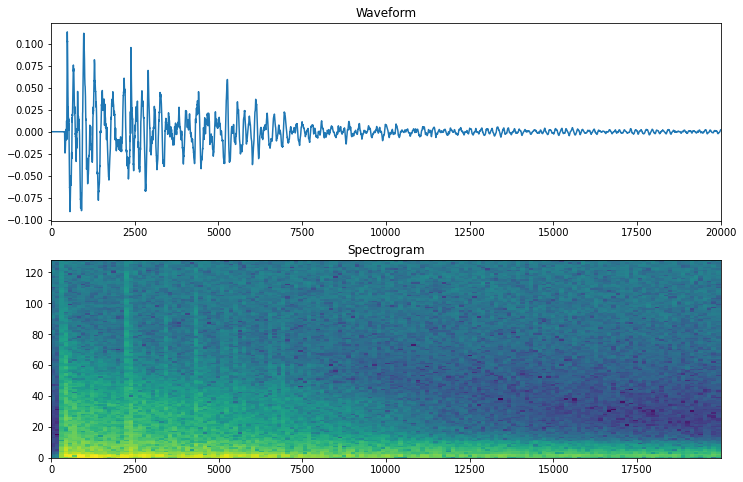

In [48]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 20000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [49]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == sounds)
  return spectrogram, label_id

In [50]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

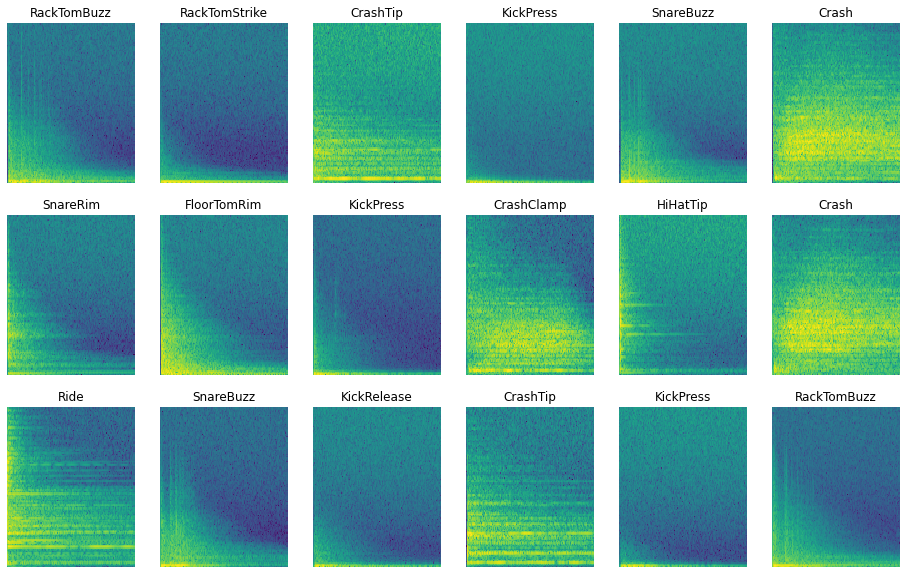

In [51]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(sounds[label_id.numpy()])
  ax.axis('off')

plt.show()

In [52]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [53]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [54]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [55]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [56]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(sounds)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (155, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)        

In [57]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [58]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
22/22 [==============================] - 12s 505ms/step - loss: 2.5900 - accuracy: 0.1862 - val_loss: 2.2497 - val_accuracy: 0.2870
Epoch 2/10
22/22 [==============================] - 5s 215ms/step - loss: 2.1457 - accuracy: 0.3109 - val_loss: 1.7598 - val_accuracy: 0.5444
Epoch 3/10
22/22 [==============================] - 5s 222ms/step - loss: 1.7547 - accuracy: 0.4464 - val_loss: 1.3991 - val_accuracy: 0.6361
Epoch 4/10
22/22 [==============================] - 5s 215ms/step - loss: 1.4959 - accuracy: 0.5029 - val_loss: 1.0756 - val_accuracy: 0.6568
Epoch 5/10
22/22 [==============================] - 5s 215ms/step - loss: 1.2481 - accuracy: 0.5841 - val_loss: 0.8555 - val_accuracy: 0.8047
Epoch 6/10
22/22 [==============================] - 5s 213ms/step - loss: 1.0737 - accuracy: 0.6275 - val_loss: 0.7094 - val_accuracy: 0.8284
Epoch 7/10
22/22 [==============================] - 5s 216ms/step - loss: 0.9672 - accuracy: 0.6688 - val_loss: 0.6593 - val_accuracy: 0.8284
Epoch

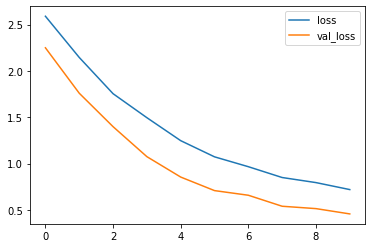

In [59]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [60]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [61]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 88%


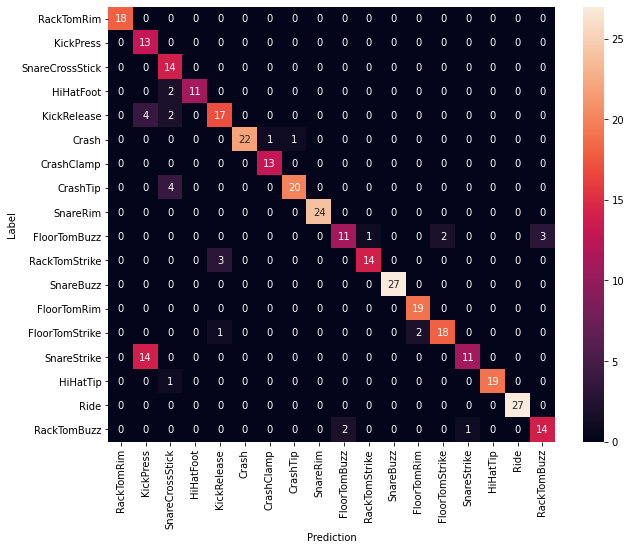

In [62]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=sounds, yticklabels=sounds, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


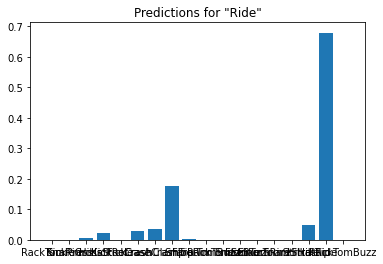

<Figure size 16000x10000 with 0 Axes>

In [67]:
sample_file = data_dir/'Ride/_DI_Ride_Tip_1111.1.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(sounds, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{sounds[label[0]]}"')
  plt.figure(figsize=(160,100), dpi=100)
  plt.show()

In [68]:
model.save("drum_sound_model")

INFO:tensorflow:Assets written to: drum_sound_model/assets


In [71]:
from os import walk
from os.path import join
import zipfile
myzip = zipfile.ZipFile('model.zip', 'w')
for dirpath, subdirs, f in os.walk('drum_sound_model'):
  for x in f:
    myzip.write(join(dirpath, x))
myzip.close()
